Машин сургалтыг ашиглан санхүүгийн датаг шинжлэх, pattern, уялдаа холбоо, бүтцийг олох зэргээр unsupervised learning-г арилжааны салбарт ашиглах боломжтой. Supervised learning-с ялгаатай нь шийдвэр гаргах биш өгөгдлөөс ойлголт гаргахад чиглэдэг.

Яг ямар боломжуудаар ашигладаг вэ?
    - Clustering
    - Dimensionality Reduction
    - Anomaly Detection
    - Market Regime Detection
    - Portfolio Optimization

Unsupervised Learning Trading Strategy
- S&P500-н хувьцаануудын үнийн датаг татаж оруулах
- Хувьцаа тус бүр дээр техник индикатор ашиглан тооцоолол хийх 
- Сарын дүнгээрээ хамгийн хөрвөх чадвар сайтай 150 хувьцааг сонгох
- Fama-French Factor & Calculate Rolling Factor Beta-г татах
- Сар бүр дээр K-Means Clustering алгоритм ашиглан хувьцаануудыг адил төстэйгөөр нь ангилах
- Сар бүр cluster-т тулгуурлан хувьцаануудыг сонгон Efficient Frontier max shape ratio ашиглан portfolio үүсгэнэ.
- Portfolio-ны өгөөжийг S&P500-н өгөөжтэй харьцуулна.   

1. S&P500-н хувьцаануудын үнийн датаг татаж оруулах

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S&P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588039   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716066   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[994088 rows x 6 columns]

2. Хувьцаа тус бүр дээр техник индикатор ашиглан тооцоолол хийх.
    - Garman-Klass Volatility
    - RSI
    - Bollinger Bands
    - ATR
    - MACD
    - Dollar Volume

Garman-Klass Volatility = ((ln(High) - ln(Low))^2) / 2 - (2ln(2) - 1)(ln(AdjClose) - ln(Opne))^2

In [4]:
df['garman_klass_vol'] = ((np.log(df['high']) -np.log(df['low']))**2) / 2 - (2*np.log(2) -1)*((np.log(df['adj close']) - np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)

    return atr.sub(atr.mean()).div(atr.std())


df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df


adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.588039   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716066   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000854        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005441        NaN       NaN   
           ABBV     12842800.0         -0.049280        NaN       NaN   
           ABT      12287500.0         -0.008237        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 YUM       1500600.0          0.000037  36.057200  4.821521   
           ZBH       3610500.0          0.000224  31.893246  4.751923   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZION      1586100.0          0.000292  46.707775  3.527329   
           ZTS       1463200.0          0.000075  42.623482  5.161192   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      71.148900  
           AAL          NaN       NaN       NaN       NaN     279.420040  
           AAPL         NaN       NaN       NaN       NaN    7253.216380  
           ABBV         NaN       NaN       NaN       NaN     475.499888  
           ABT          NaN       NaN       NaN       NaN     415.406831  
...                     ...       ...       ...       ...            ...  
2023-09-26 YUM     4.851489  4.881456  0.142547 -1.363696     185.213334  
           ZBH     4.791592  4.831260 -0.381708 -0.881067     405.157010  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZION    3.582765  3.638202 -0.161699 -0.164625      53.263340  
           ZTS     5.220007  5.278822  0.651515 -1.188278     258.178041  

[994088 rows x 14 columns]

3. Сар бүрийн хамгийн хөрвөх чадвар сайтай 150 хувьцааг сонгох

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          136.444146   39.152687 -1.033887  3.694119  3.549210   
           AAL        287.915796   39.429932  0.190822  3.827635  3.672028   
           AAPL      4034.583670   26.924873 -0.967900  3.370842  3.284211   
           ABBV       343.971762   41.160301 -0.526809  3.841588  3.745051   
           ABT        213.736343   38.669388 -1.064842  3.709289  3.665571   
...                          ...         ...       ...       ...       ...   
2023-09-30 YUM        176.806022  123.426186  0.142547  4.881456  4.821521   
           ZBH        192.575129  112.216316 -0.381708  4.831260  4.751923   
           ZBRA       105.780863  223.960007 -0.057389  5.677342  5.400991   
           ZION       100.279835   33.581326 -0.161699  3.638202  3.527329   
           ZTS        288.993350  176.447540  0.651515  5.278822  5.161192   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.621664         -0.001810  0.567157  73.421416  
           AAL     3.749832         -0.000966 -0.418771  40.718971  
           AAPL    3.327527         -0.003119 -0.142789  55.537341  
           ABBV    3.793320         -0.053947  0.145677  49.376858  
           ABT     3.687430         -0.009962  0.335557  56.962459  
...                     ...               ...       ...        ...  
2023-09-30 YUM     4.851489          0.000037 -1.363696  36.057200  
           ZBH     4.791592          0.000224 -0.881067  31.893246  
           ZBRA    5.539167          0.000133 -1.600791  29.494977  
           ZION    3.582765          0.000292 -0.164625  46.707775  
           ZTS     5.220007          0.000075 -1.188278  42.623482  

[46937 rows x 9 columns]

Хувьцаа тус бүрийн 5 жилийн dollar volume-н rolling average-г тооцоольё

In [6]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134335  0.402199  3.706314  3.604673  3.655494   
           AAPL     26.281525 -1.038688  3.354535  3.296770  3.325653   
           ABBV     41.009071 -0.893132  3.880188  3.771814  3.826001   
           ABT      34.630024 -1.035224  3.665095  3.564121  3.614608   
           ACN     104.350327 -0.996806  4.668056  4.644779  4.656418   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       32.300549 -1.078816  3.563843  3.499366  3.531604   
           WFC      40.290813 -0.558742  3.790225  3.709473  3.749849   
           WMT     162.500000 -0.196379  5.116986  5.081613  5.099300   
           XOM     115.355156  0.601335  4.784477  4.704273  4.744375   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.131596  62.203571  
           AAPL           -0.002307 -0.195978  49.891131  
           ABBV           -0.041756 -0.760594  27.477656  
           ABT            -0.006476 -0.650888  38.008805  
           ACN            -0.004026 -0.135456  53.823713  
...                             ...       ...        ...  
2023-09-30 VRTX            0.000037  0.027907  52.406728  
           VZ             -0.000067 -0.350385  42.222474  
           WFC             0.000136 -0.282325  40.920287  
           WMT             0.000024  0.399459  54.722508  
           XOM             0.000068  1.400623  59.440186  

[12516 rows x 8 columns]

4. Сар бүрийн өгөөжийг өөр өөр цагийн ангилалт тооцоолох 

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534168  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.818516 -0.906642  3.691040  3.597289  3.644164   
           ABBV     68.772293  0.375557  4.307973  4.215227  4.261600   
           ABT      48.969299 -1.040044  3.949284  3.902136  3.925710   
           ACN     130.375076 -0.986514  4.889487  4.810123  4.849805   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       32.300549 -1.078816  3.563843  3.499366  3.531604   
           WFC      40.290813 -0.558742  3.790225  3.709473  3.749849   
           WMT     162.500000 -0.196379  5.116986  5.081613  5.099300   
           XOM     115.355156  0.601335  4.784477  4.704273  4.744375   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018697  41.051792  -0.014108   
           AAPL           -0.000945 -0.039275  69.196648   0.096808   
           ABBV           -0.029822  0.473813  55.247832   0.022728   
           ABT            -0.004349  0.276132  53.844847   0.021275   
           ACN            -0.003359  0.352343  69.365045   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 VRTX            0.000037  0.027907  52.406728   0.009617   
           VZ             -0.000067 -0.350385  42.222474  -0.056890   
           WFC             0.000136 -0.282325  40.920287  -0.015500   
           WMT             0.000024  0.399459  54.722508  -0.000676   
           XOM             0.000068  1.400623  59.440186   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[10340 rows x 14 columns]

5. Fama-French Factor-уудыг татан Rolling Factor Beta-г тооцоолох

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1) # Risk Free column ni hereggui

factor_data.index = factor_data.index.to_timestamp() # factor_data nii date-g ogogdoltei adilhan formatad oruulj bna

factor_data = factor_data.resample('M').last().div(100) # ognoog dataniihtai adil sariin suul bolgoj bna

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10340 rows x 6 columns]

- 10 сараас бага дататай хувьцаануудыг хасах

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10305 rows x 6 columns]

- Rolling Factor Beta-г тооцоолох

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456467 -0.445783 -0.312765 -0.079230  0.800476
           VZ      0.332656 -0.165646  0.267344  0.310365  0.106902
           WFC     1.121746  0.300523  2.061531 -0.439488 -1.517556
           WMT     0.700557 -0.315603 -0.413432 -0.142907  0.508470
           XOM     0.983510 -1.093757  1.756776 -0.640865 -0.368454

[10305 rows x 5 columns]

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10055 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10055 non-null  float64
 1   bb_high           10055 non-null  float64
 2   bb_low            10055 non-null  float64
 3   bb_mid            10055 non-null  float64
 4   garman_klass_vol  10055 non-null  float64
 5   macd              10055 non-null  float64
 6   rsi               10055 non-null  float64
 7   return_1m         10055 non-null  float64
 8   return_2m         10055 non-null  float64
 9   return_3m         10055 non-null  float64
 10  return_6m         10055 non-null  float64
 11  return_9m         10055 non-null  float64
 12  return_12m        10055 non-null  float64
 13  Mkt-RF            10055 non-null  float64
 14  SMB               10055 non-null  float64
 15  HML        

6. Сар бүрд хувьцаануудыг онцлогоор нь хуваан K-Means Clustering Algorithm-г хэрэгжүүлэх

In [13]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.691040  3.597289  3.644164         -0.000945   
           ABBV    0.375557  4.307973  4.215227  4.261600         -0.029822   
           ABT    -1.040044  3.949284  3.902136  3.925710         -0.004349   
           ACN    -0.986514  4.889487  4.810123  4.849805         -0.003359   
...                     ...       ...       ...       ...               ...   
2023-09-30 VRTX    0.029799  5.879295  5.838959  5.859127          0.000037   
           VZ     -1.078816  3.563843  3.499366  3.531604         -0.000067   
           WFC    -0.558742  3.790225  3.709473  3.749849          0.000136   
           WMT    -0.196379  5.116986  5.081613  5.099300          0.000024   
           XOM     0.601335  4.784477  4.704273  4.744375          0.000068   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051792  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196648   0.096808   0.015250   0.044955   
           ABBV    0.473813  55.247832   0.022728   0.098590   0.091379   
           ABT     0.276132  53.844847   0.021275   0.034308   0.034801   
           ACN     0.352343  69.365045   0.064180   0.048454   0.037202   
...                     ...        ...        ...        ...        ...   
2023-09-30 VRTX    0.027907  52.406728   0.009617  -0.000923  -0.000208   
           VZ     -0.350385  42.222474  -0.056890  -0.016122  -0.033458   
           WFC    -0.282325  40.920287  -0.015500  -0.057917  -0.013554   
           WMT     0.399459  54.722508  -0.000676   0.010014   0.012354   
           XOM     1.400623  59.440186   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494521  0.362283   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199020   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166701   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.504915 -0.411099   
           VZ      -0.021495  -0.014100   -0.006158  0.302532 -0.212073   
           WFC      0.016712   0.000702    0.003255  1.137639  0.314484   
           WMT      0.017574   0.016553    0.020256  0.740056 -0.261893   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051368   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591145  0.647780  0.458079        3  
           ABBV   -0.033101  0.241982  0.164921        2  
           ABT    -0.529385  0.252407  0.970212        2  
           ACN    -0.328213  0.267788  0.168884        3  
...                     ...       ...       ...      ...  
2023-09-30 VRTX   -0.481425  0.057280  0.943566        3  
           VZ      0.344589  0.318167  0.000827        2  
           WFC     2.009073 -0.404336 -1.468838        1  
           WMT    -0.522676 -0.126426  0.642626        3  
           XOM     1.707833 -0.675678 -0.284024        3  

[10055 rows x 19 columns]

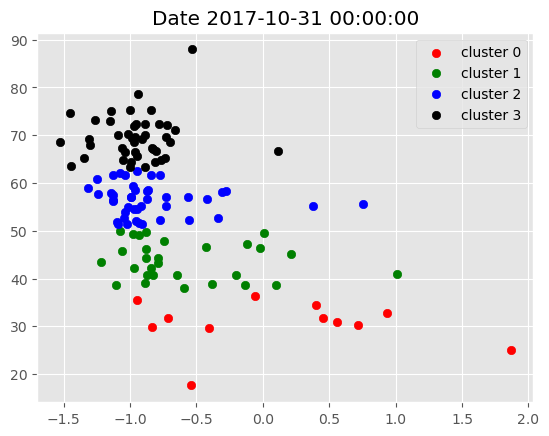

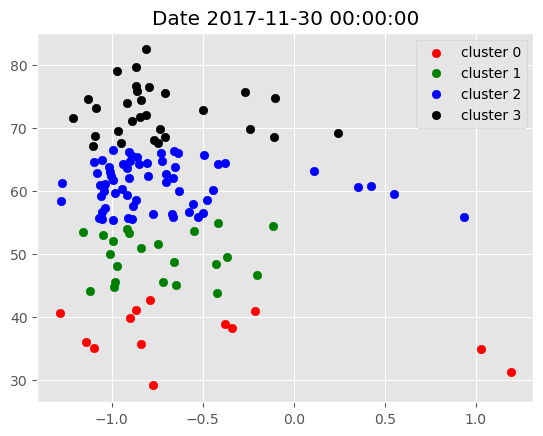

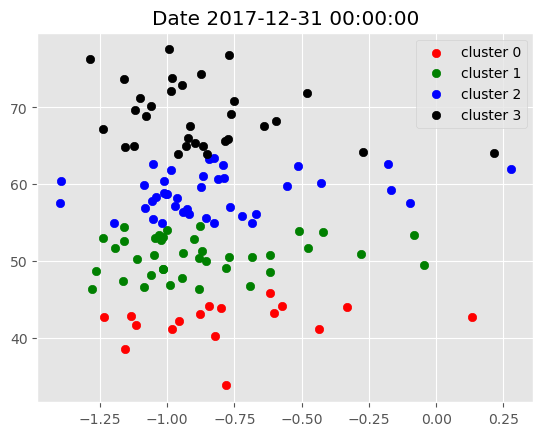

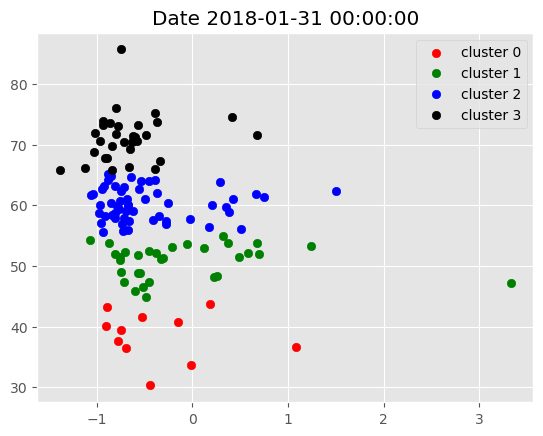

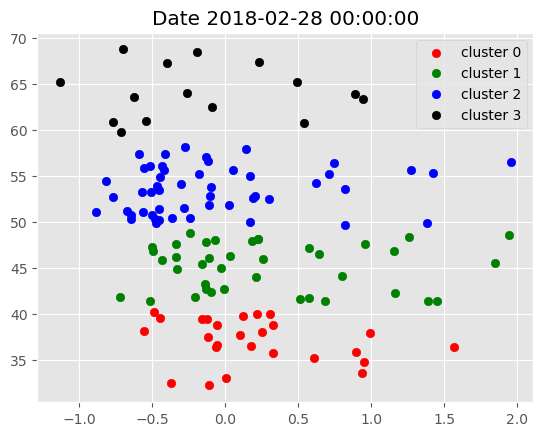

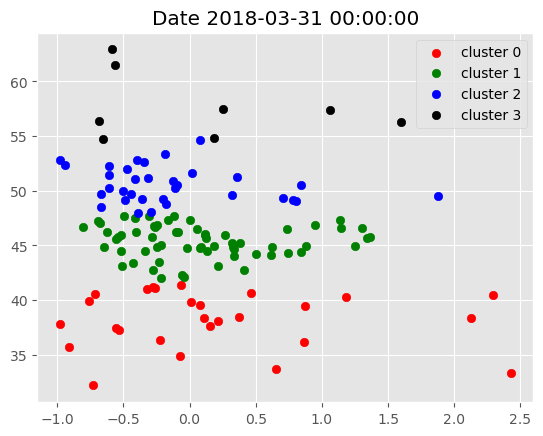

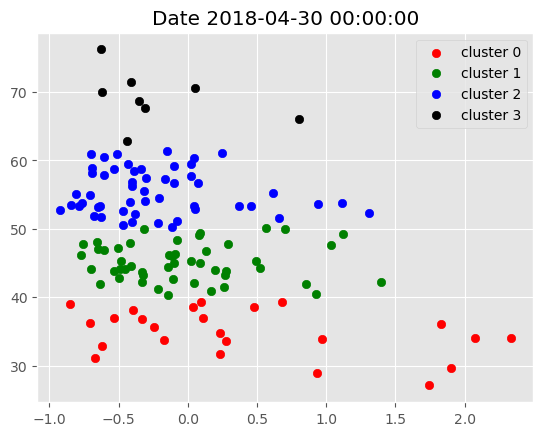

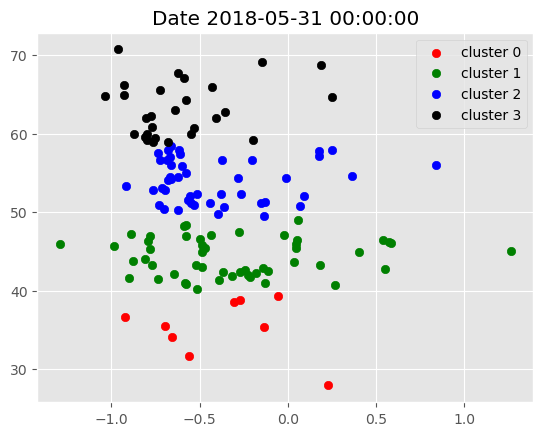

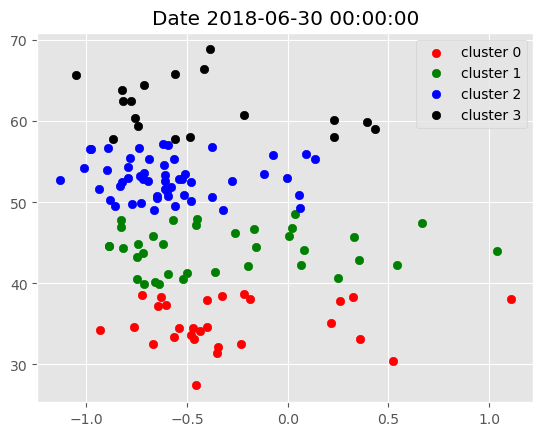

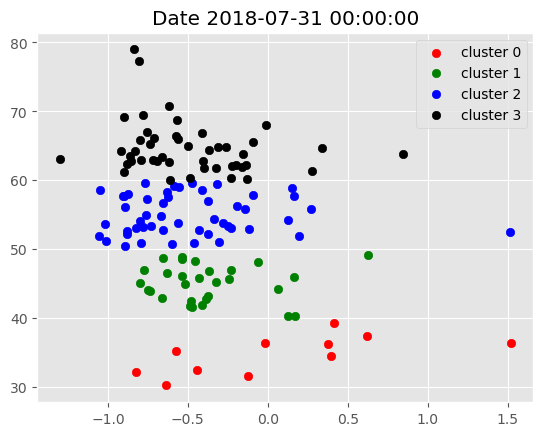

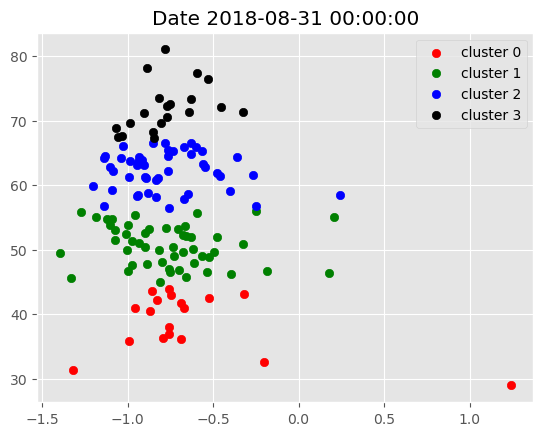

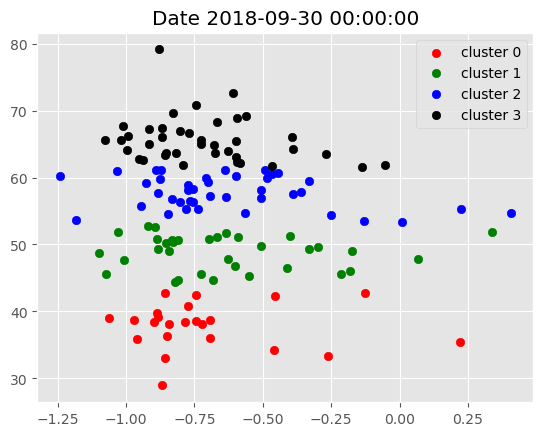

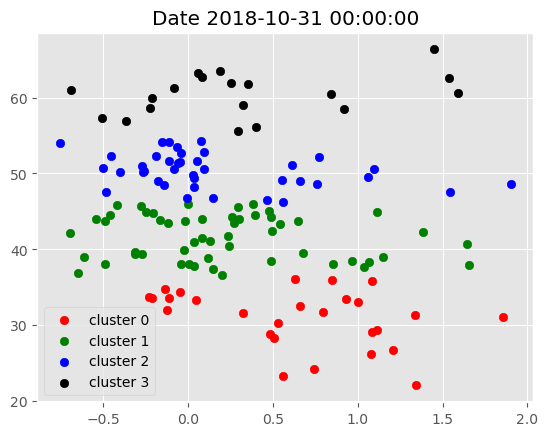

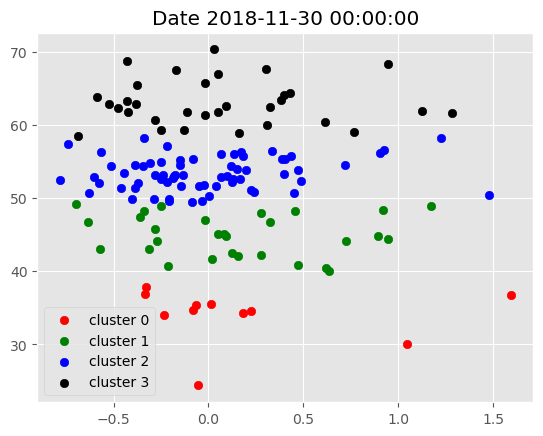

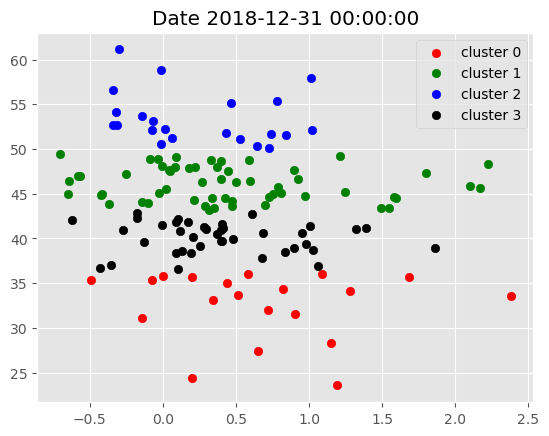

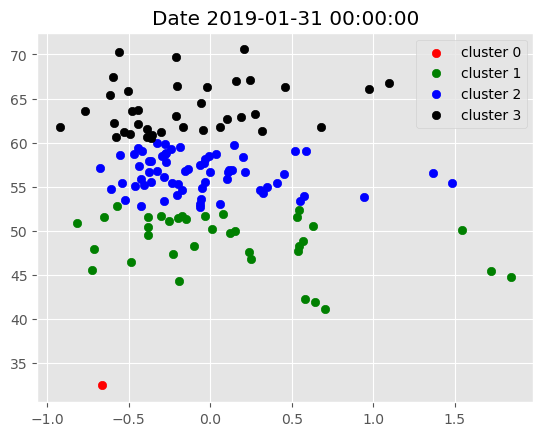

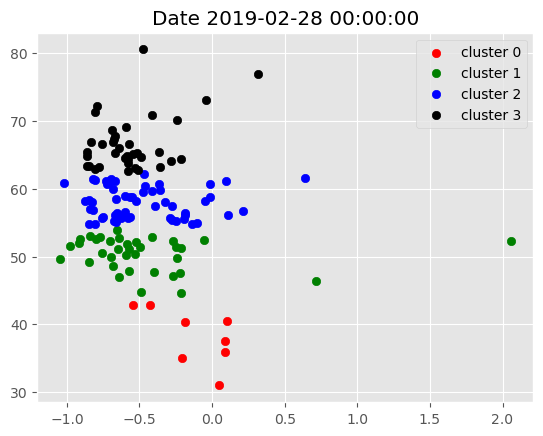

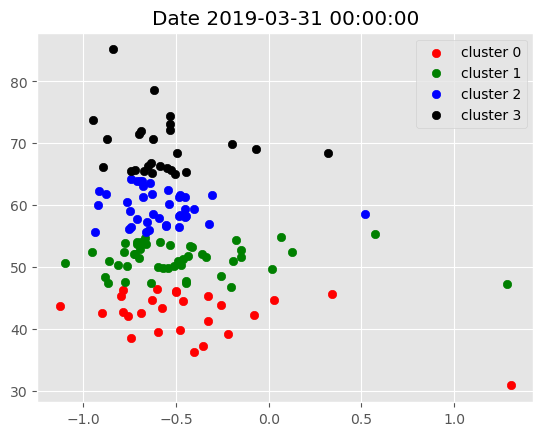

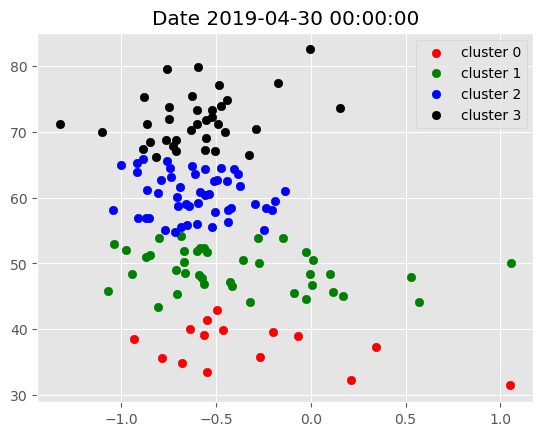

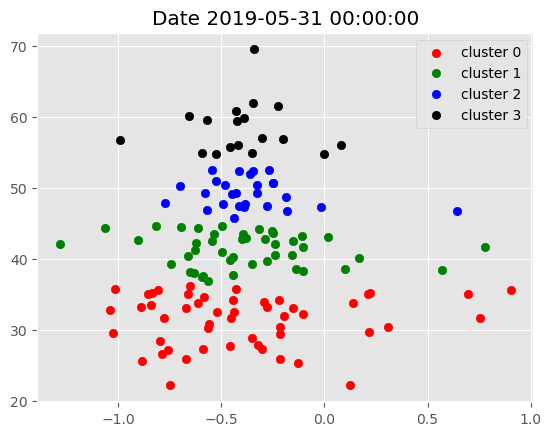

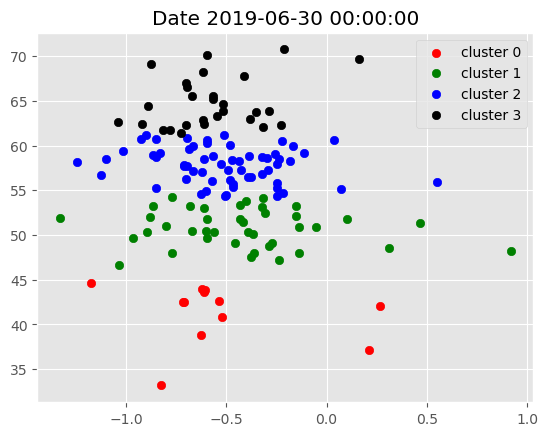

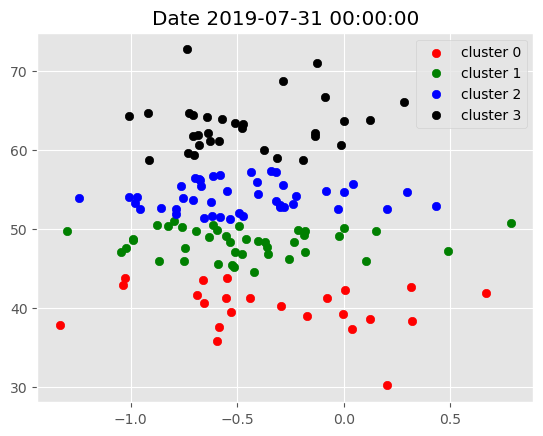

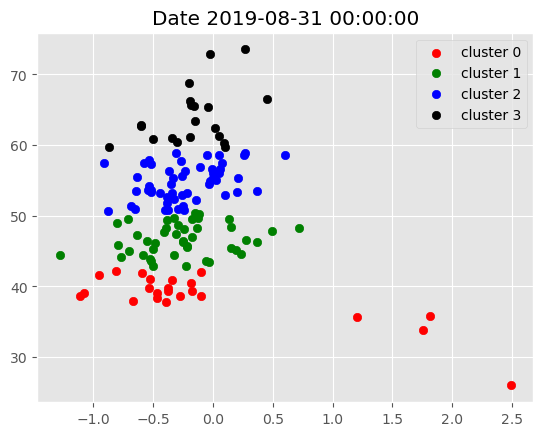

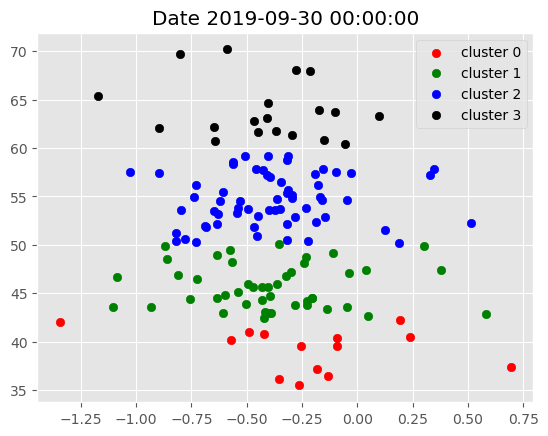

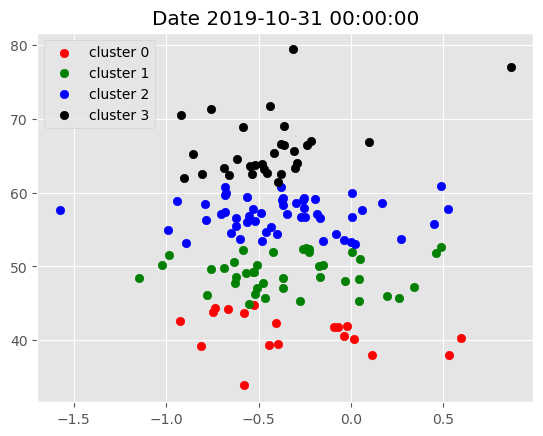

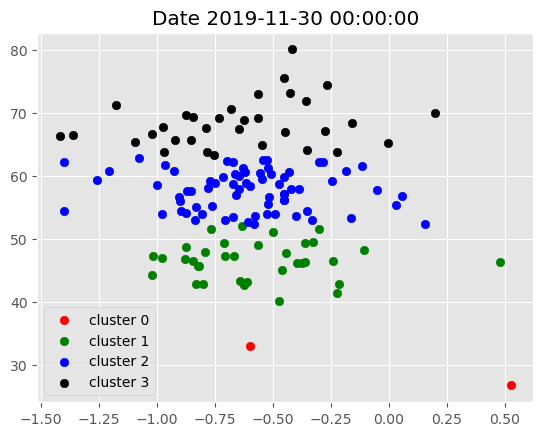

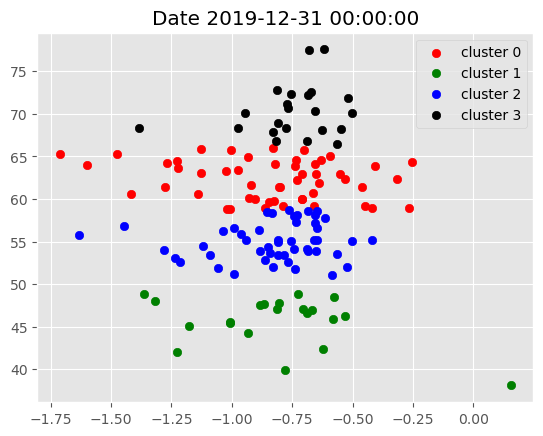

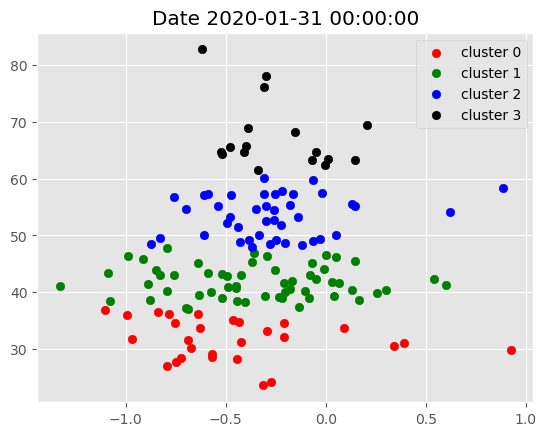

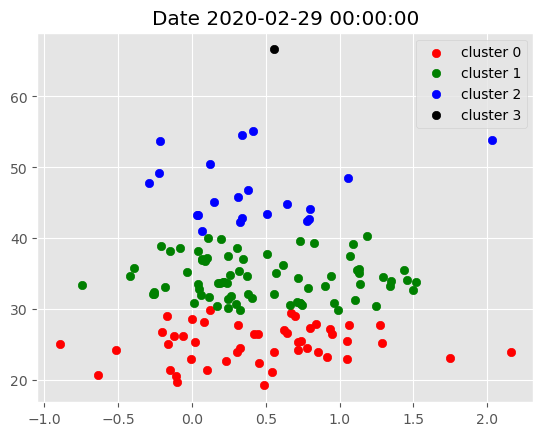

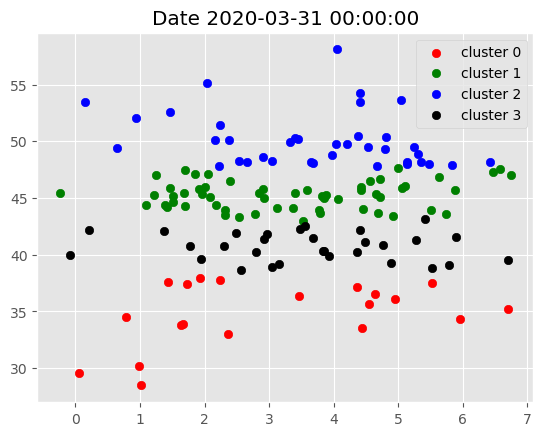

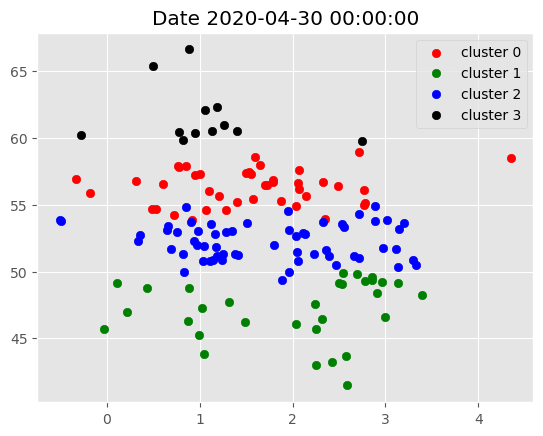

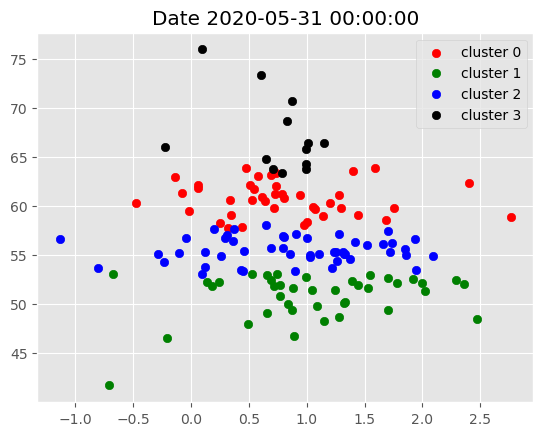

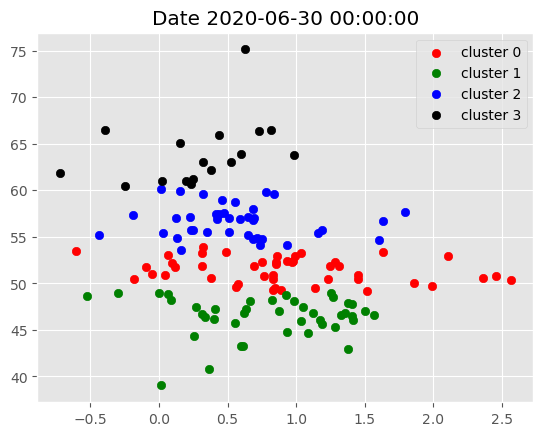

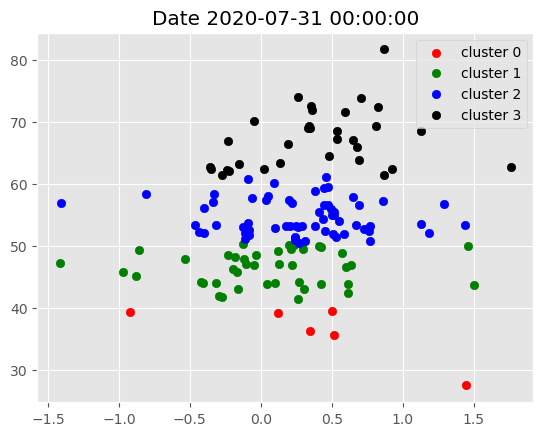

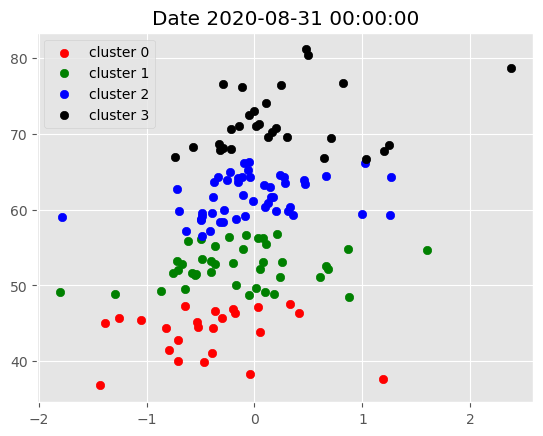

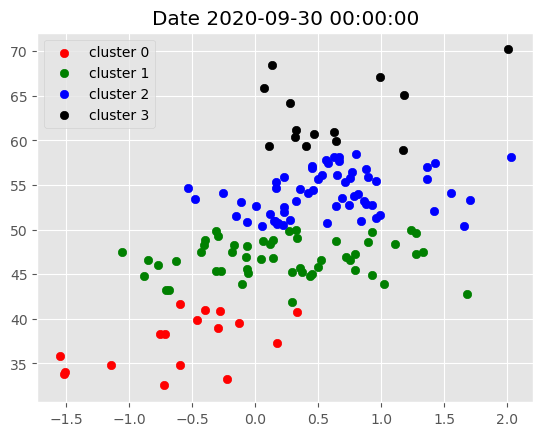

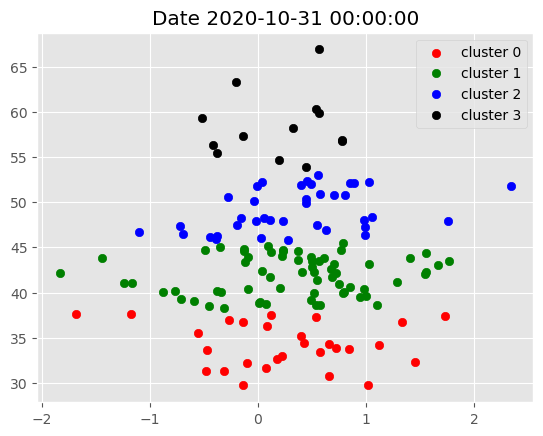

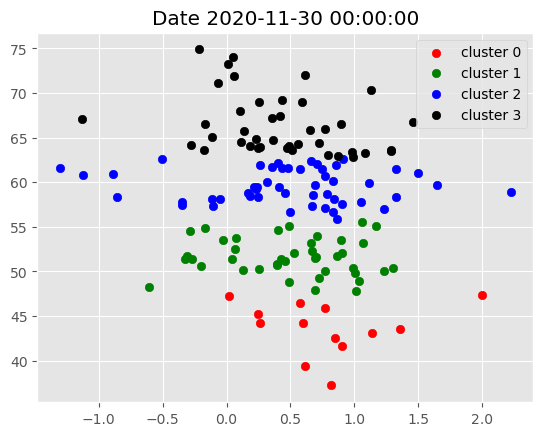

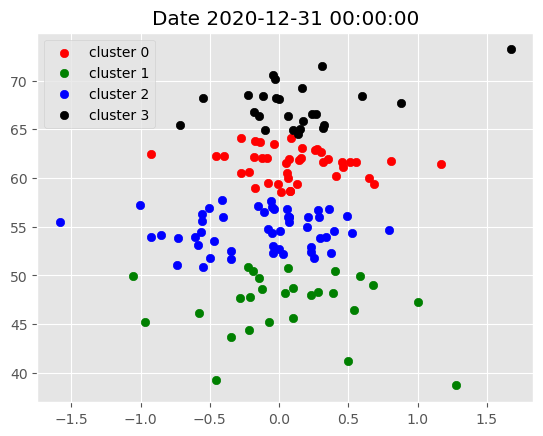

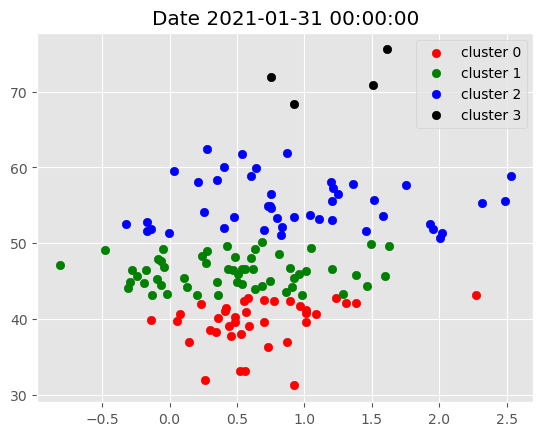

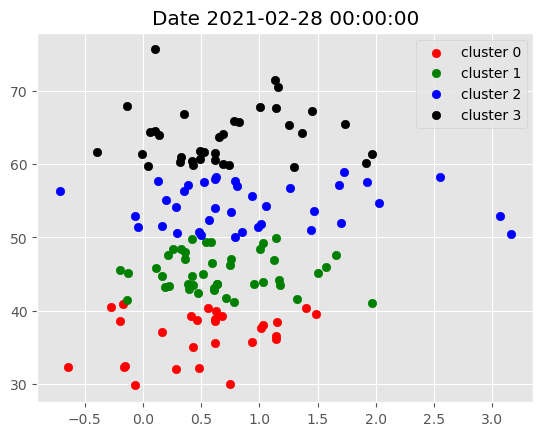

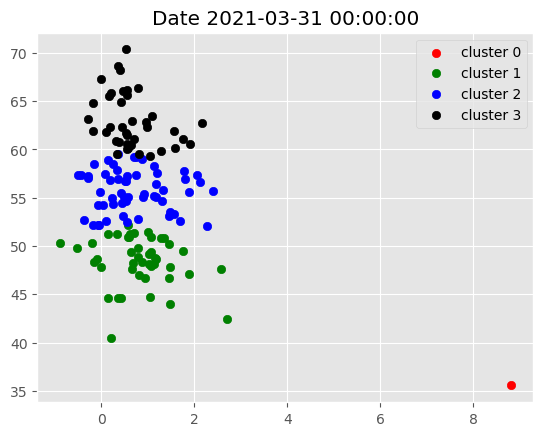

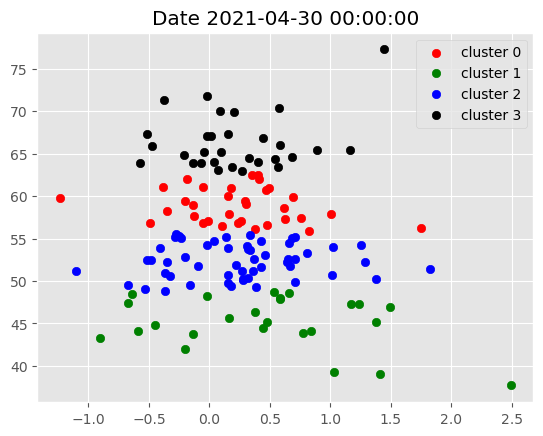

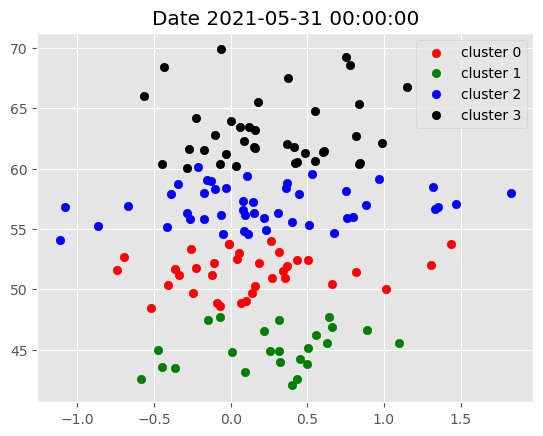

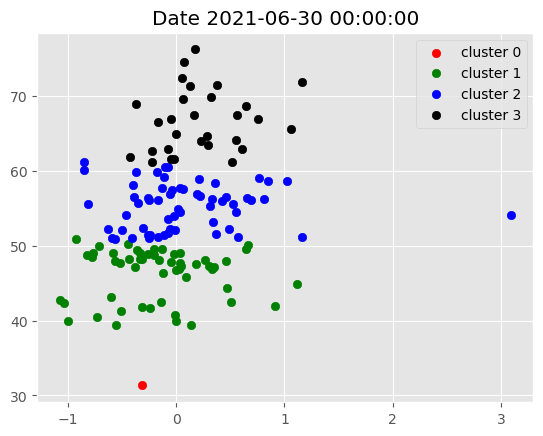

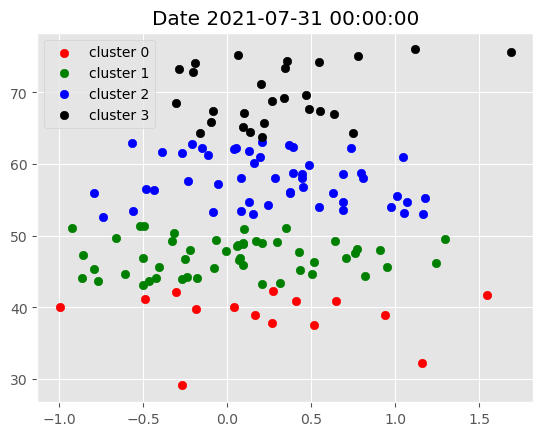

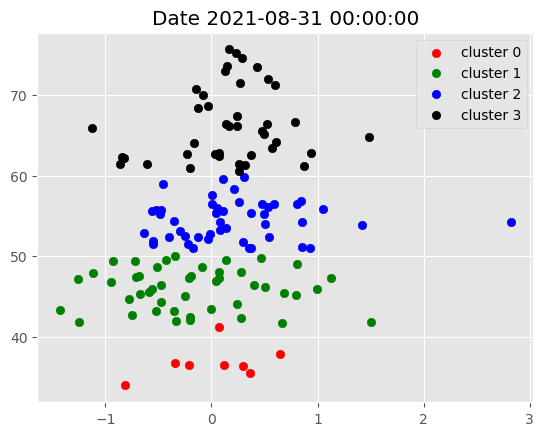

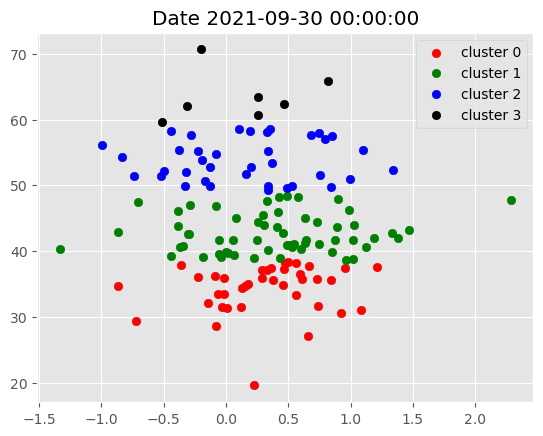

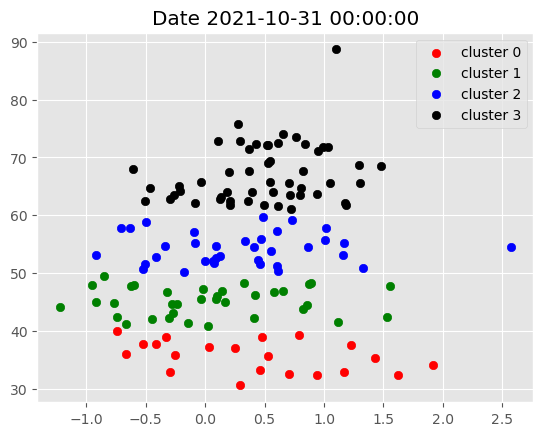

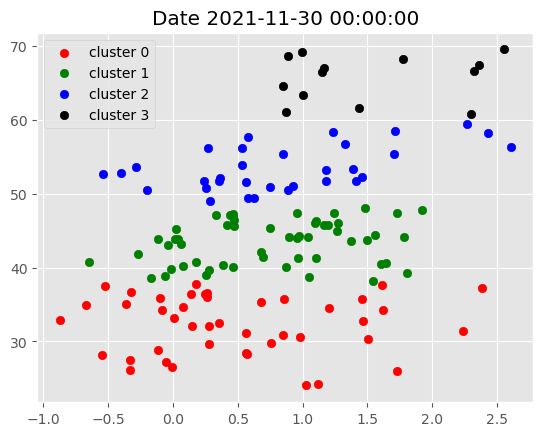

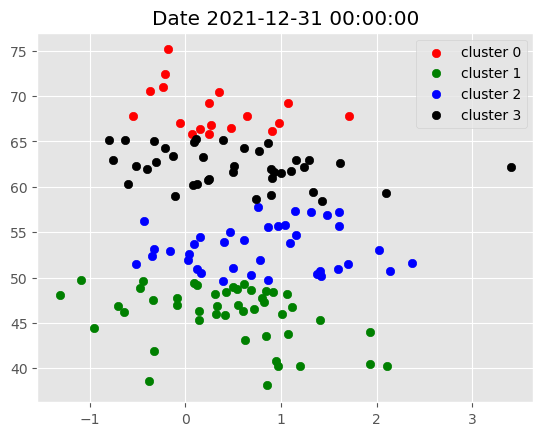

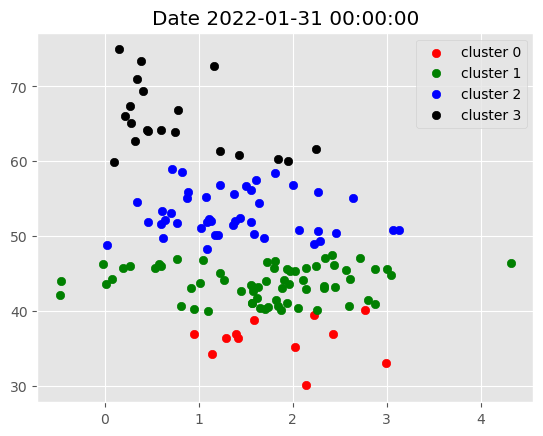

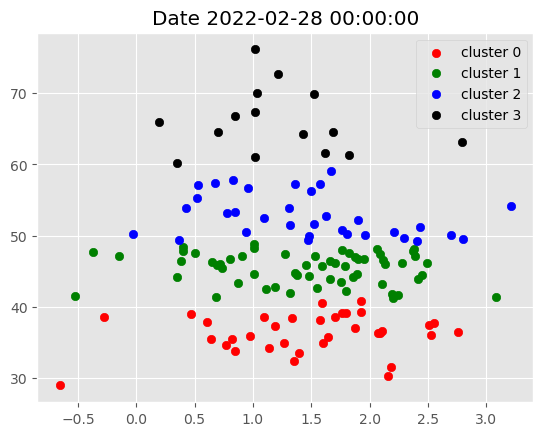

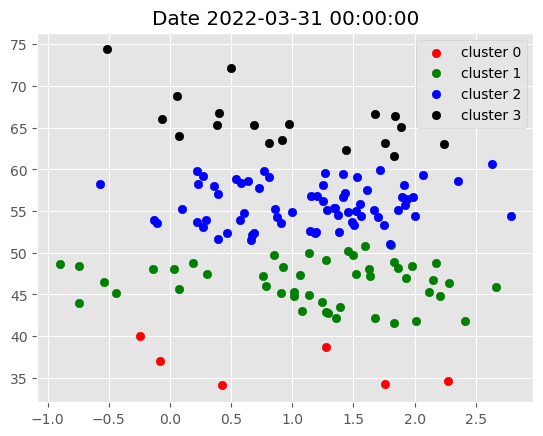

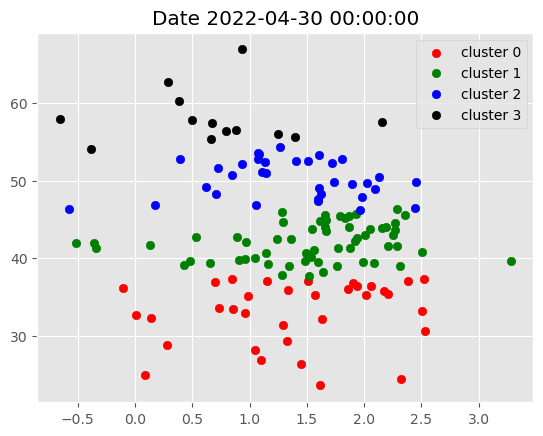

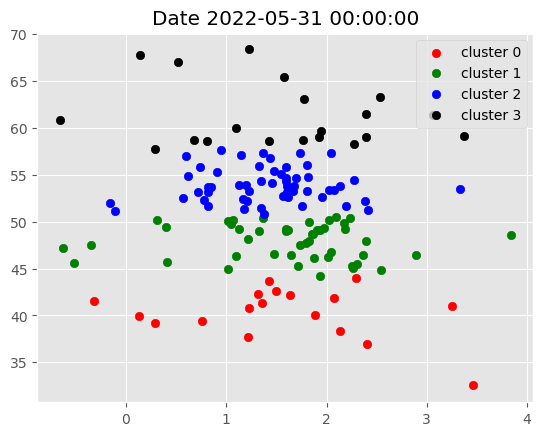

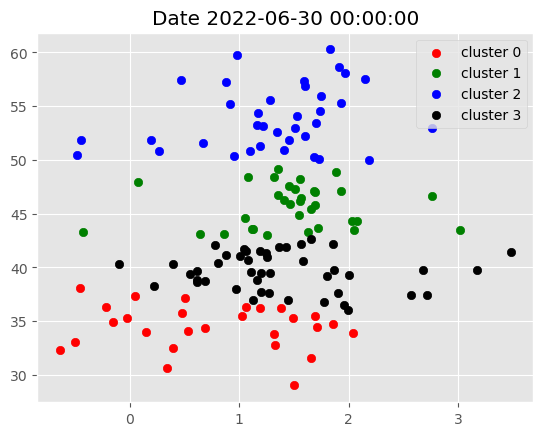

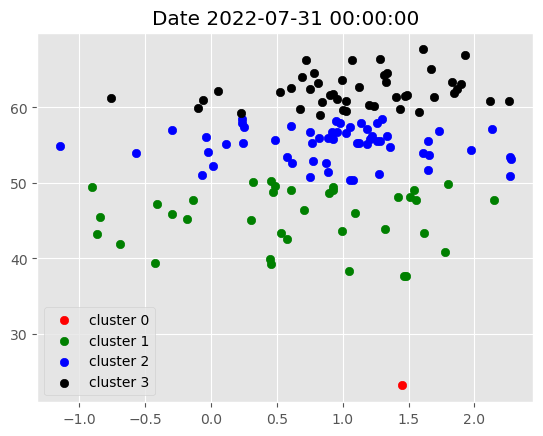

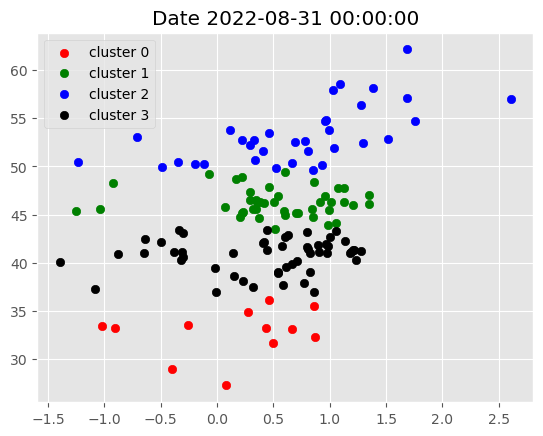

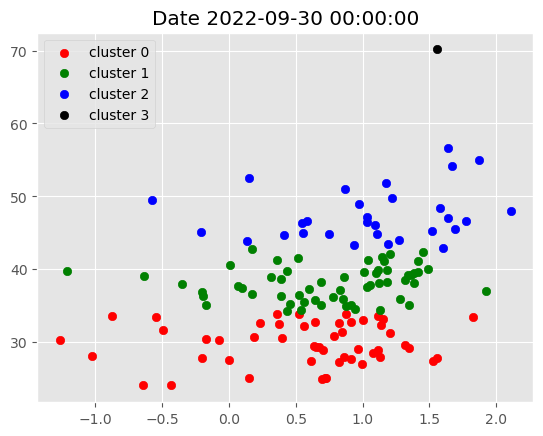

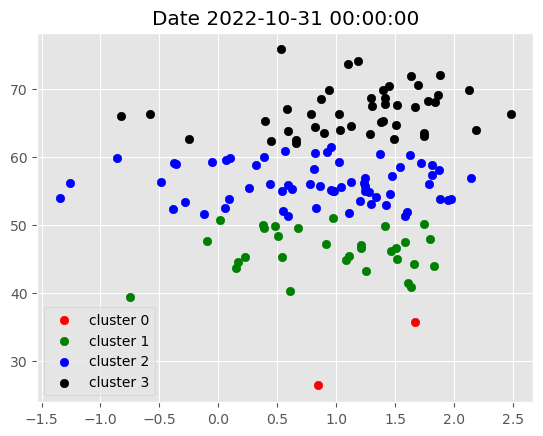

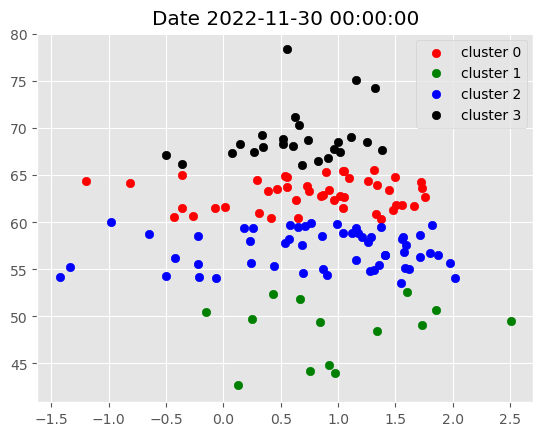

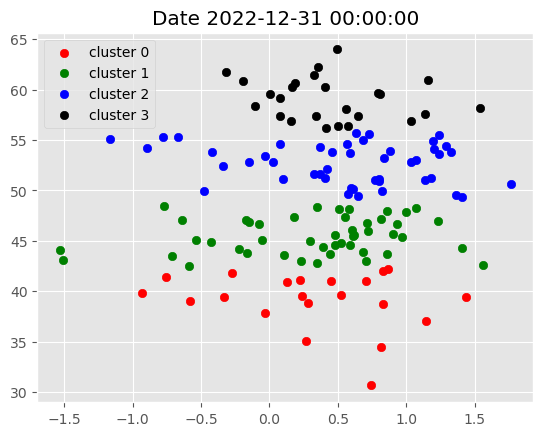

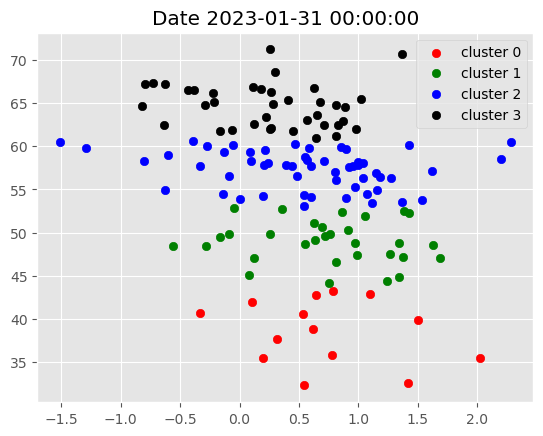

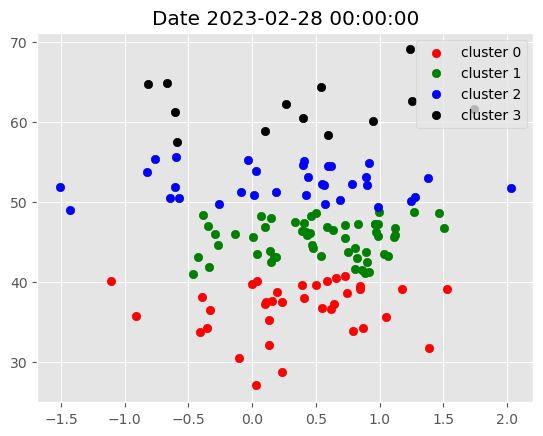

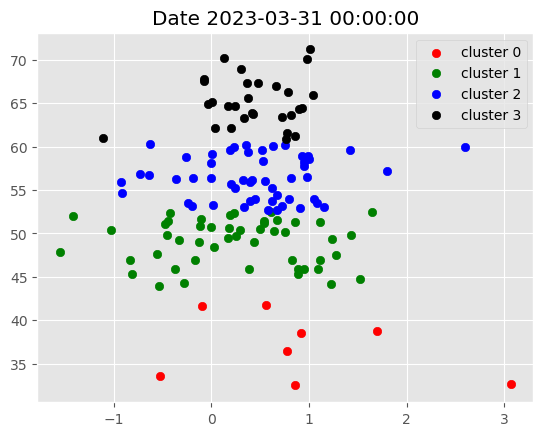

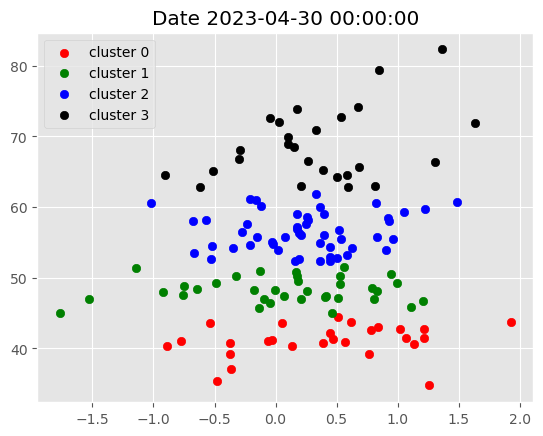

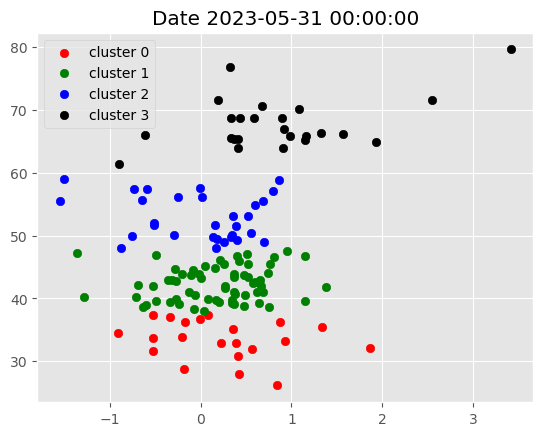

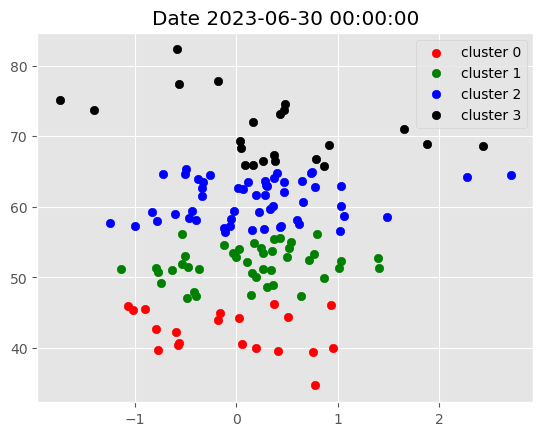

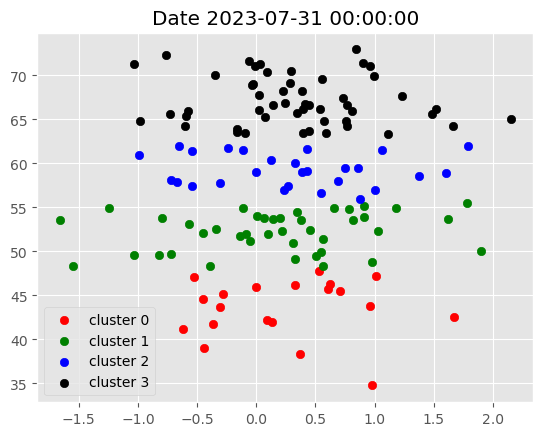

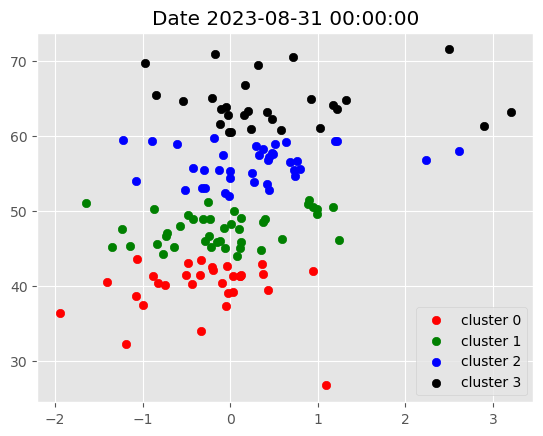

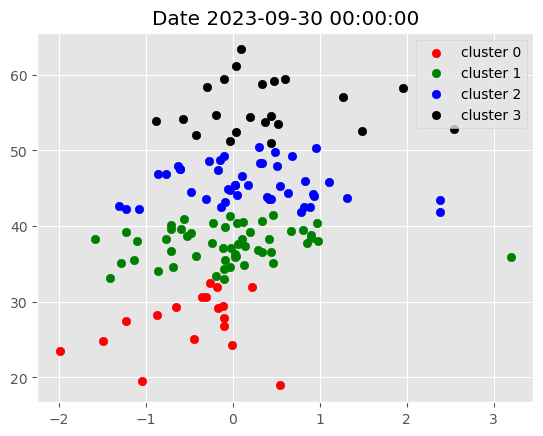

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g) # rsi & atr

7. Сар бүрд дээрх cluster-д үндэслэн хувьцаануудыг сонгон Efficient Frontier max shape ratio optimization ашиглан portfolio үүсгэх

In [20]:
filtered_df = data[data['cluster']==3].copy() # rsi ni 70 tai bga huwtsanud

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['

Portfolio optimization функцийг тодорхойлох

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

- Сонгосон хувьцаануудынхаа сүүлийг үеийн датаг татах

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134323   26.281521   41.009075  34.630024  104.350311   
2016-11-01  38.363213   25.807007   41.501656  34.462341  104.260536   
2016-11-02  38.276459   25.830149   41.751621  34.153461  106.477890   
2016-11-03  38.054207   25.553282   41.089958  33.871071  104.987679   
2016-11-04  38.402084   25.322947   41.200233  34.497650  105.239059   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.848328  153.117371  96.933411  315.680695   
2023-09-26  12.700000  171.733749  152.384705  95.700241  309.327057   
2023-09-27  12.610000  170.205750  151.612442  95.004089  313.081512   
2023-09-28  12.920000  170.465424  150.741165  97.579834  299.527710   
2023-09-29  12.810000  170.984741  147.582764  96.316818  305.841522   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   75.138802   72.279999  51.253319   26.700006  ...   
2016-11-01  106.870003   75.017952   70.099998  50.406006   26.534739  ...   
2016-11-02  105.889999   77.658981   68.680000  50.298023   26.250111  ...   
2016-11-03  107.169998   77.097984   67.610001  48.304375   25.956301  ...   
2016-11-04  106.199997   76.882202   69.440002  47.664742   25.910391  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  240.020004  205.669998  62.130001  136.297150  ...   
2023-09-26  506.299988  237.240005  201.660004  61.259998  133.792526  ...   
2023-09-27  502.600006  242.630005  202.279999  61.009998  134.770416  ...   
2023-09-28  504.670013  243.309998  207.889999  61.279999  137.923645  ...   
2023-09-29  509.899994  240.580002  206.910004  60.599998  138.153152  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                        
                WMT     WYNN       XOM  
Date                                    
2016-10-31  6389000  1341600  16663800  
2016-11-01  8838600  3722300  13050600  
2016-11-02  7645300  2542400  11226100  
2016-11-03  6803900  9050400   8836500  
2016-11-04  7262100  3223800  13877100  
...             ...      ...       ...  
2023-09-25  3486500  1387800  11316000  
2023-09-26  4811900  1454000  11805400  
2023-09-27  5237000  2050000  23976200  
2023-09-28  3872400  1290400  16808100  
2023-09-29  6279300  1326800  18810700  

[1740 rows x 918 columns]

- Portfolio-д орох боломжтой хувьцаа тус бүрийн өдрийн өгөөжийг тооцоолох 

- Сар бүрийн эхэнд хувьцаануудыг сонгон түүний ирэх сарын жинг тооцоолох

- Хэрэв тухайн сард Maximum sharpe ratio optimization бүтэлгүйтвэл, тэнцүү жингүүдийг оноох.

- Portfolio-ны өдөр бүрийн өгөөжийг тооцоолох

In [21]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001361
2017-11-02,0.002909
2017-11-03,0.006310
2017-11-06,0.003008
2017-11-07,0.002704
...,...
2023-09-25,0.003641
2023-09-26,-0.011470
2023-09-27,0.005189


8. Portfolio-ны өгөөжийг S&P500-н өгөөжтэй харьцуулах

In [22]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df


[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001361,0.001321
2017-11-02,0.002909,0.000388
2017-11-03,0.006310,0.003333
2017-11-06,0.003008,0.001546
2017-11-07,0.002704,-0.000695
...,...,...
2023-09-25,0.003641,0.004196
2023-09-26,-0.011470,-0.014800
2023-09-27,0.005189,0.000399
2023-09-28,0.007977,0.005781


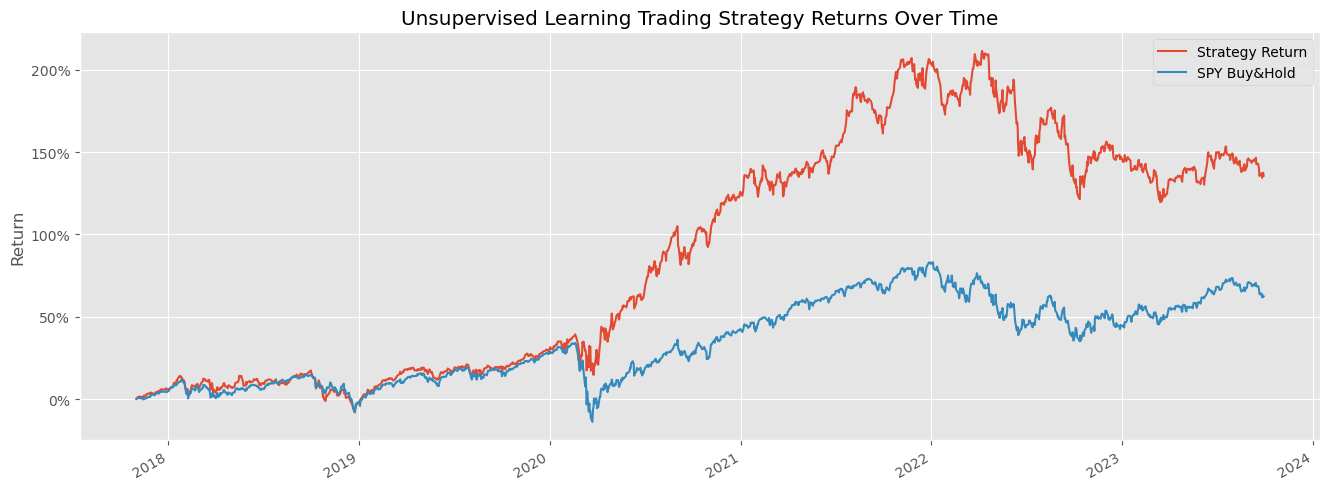

In [23]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()